# Investigación para estrategia de retención de clientes para Model Fitness

La cadena de gimnasios Model Fitness está desarrollando una estrategia de interacción con los clientes orientada a la retención de los mismos. Buscando una mejor comprensión de su clientela, la empresa digitalizó varios perfiles de clientes, los cuales nos fueron provistos y nos ayudarán a establecer una estrategia de retención una vez analizados.

A continuación se enlistan los distintos apartados del reporte:

* 1 - Descarga de datos
* 2 - Análisis exploratorio de datos
* 3 - Modelo para predecir la cancelación de usuarios
* 4 - Creación de clústeres de usuarios
* 5 - Conclusiones

## Descarga y preprocesamiento de datos

Antes que nada se cargarán las librerías a ser utilizadas, posteriormente, se realizará la carga del documento donde se encuentran los datos a ser trabajados y se obtendrá la información de esta misma para comenzar tener una idea sobre cómo será necesario limpiar la información.

In [107]:
#Importación de librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as stats
from scipy import stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

In [108]:
#Importación del archivo csv

data = pd.read_csv('/datasets/gym_churn_us.csv')

In [109]:
#Obtención de información referente a la base

data.info()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Para una mejor comprensión de estos datos, a continuación se presenta una breve descripción de las columnas:

*Género (Opciones 1 o 0)
*Cercanía al negocio (Opciones 1 o 0)
*Compañía asociada (Opciones 1 o 0 sobre si el cliente proviene de una compañía asociada)
*Promo_friends (Opciones 1 o 0 sobre si el cliente usó promoción al inscribirse)
*Phone (Opciones 1 o 0 sobre si el cliente dejó un número celular)
*Periodo del contrato (1, 3, 6 o 12 meses)
*Visitas grupales (Opciones 1 o 0 sobre si el cliente participa en sesiones grupales)
*Edad
*Cargos adicionales totales
*Meses para terminar contrato
*Vida (Años del usuario como cliente)
*Frecuencia de clases
*Frecuencia de clases del mes corriente
*Abandono del servicio

Es posible observar que no existen datos nulos para ninguna de las columnas, por lo que no será necesario eliminar ningún registro por este motivo, aunque hace falta comprobar que no existan registros duplicados. A continuación eliminaremos los registros duplicados en caso de que existan, ya que muy dificilmente dos usuarios coincidirían en exactamente todas las características.

In [110]:
#Eliminación de duplicados

data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Como podemos observar, no existen datos duplicados que necesiten que ser eliminados. A continuación cambiaremos el tipo de datos de la columna de meses para la finalización del contrato, ya que como podemos observar maneja datos enteros y no con decimales.

In [111]:
#Cambio de tipo de dato a int64 de la columna de enteros sobre meses antes de la finalización del contrato

data['Month_to_end_contract']=data['Month_to_end_contract'].astype('int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   int64  
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Finalmente, antes de proceder al análisis de la información, y para cumplir con las mejores prácticas respecto a nombres de columnas, todos estos serán transformados en minúsculas.

In [112]:
#Conversión de nombres de columnas a minúsculas

data.columns = data.columns.str.lower()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Con la información limpia y dentro de las mejores prácticas tras el preprocesamiento, procedemos al análisis de la misma.

## Análisis emploratorio de datos

Para llevar a cabo el análisis, comenzaremos obteniendo las principales características de cada columna; analizaremos los valores medios de cada una para usuarios que se salen en el mes en cuestión y los que se quedan; trazaremos digramas e histogramas para comprender mejor esta relación, así como una matriz de correlaciones.

Comenzaremos por analizar las características de cada columna, pasándolas a través de un bucle.

In [113]:
#Características de cada columna

for column in data.columns:
    print(column)
    print(data[column].describe())
    print()

gender
count    4000.000000
mean        0.510250
std         0.499957
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: gender, dtype: float64

near_location
count    4000.000000
mean        0.845250
std         0.361711
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: near_location, dtype: float64

partner
count    4000.000000
mean        0.486750
std         0.499887
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: partner, dtype: float64

promo_friends
count    4000.000000
mean        0.308500
std         0.461932
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: promo_friends, dtype: float64

phone
count    4000.000000
mean        0.903500
std         0.295313
min         0.000000
25%         1.000000
50%         1.000000
75%         1.0000

Como podemos observar, al tatarse la mayoría de los datos de booleanos, donde 1's y 0's implican una cierta característica, las medias resultan muy informativas. Por ejemplo, podemos observar que en cuanto a género, la división es prácticamente equitativa, mientras que podemos estar seguros de que más del 90% de los clientes dejaron su número telefónico. fuera de esto, la desviación estandar nos resulta muy útil, especialmente para las columnas con datos que no son booleanos. Los cuartiles, especialmente en los datos de tipo booleano resultan un poco redundantes, dada la naturaleza de la información. 

Dada la relevancia de la media para nuestro conjunto de datos, analicemos la media de estos para dos grupos que continuaremos utilizando a lo largo de la investigación: Usuarios que abandonaron y usuarios que permanecen.

In [114]:
#Medias por grupo de usuarios

mean_by_churn = data.groupby('churn').mean().reset_index()
display(mean_by_churn)

,churn,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


A primera vista podemos encontrar tanto diferencias significativas, como valores prácticamente indistinguibles entre ambos grupos. Aparentemente el abandono del gimnasio es independiente del género, la edad o la disposición a compartir el teléfono; pero el entrar por una compañía asociada, por contacto de un amigo, encontrarse cerca o levantar un contrato por un periodo más largo, promueven el que los clientes se mantengan. 

Para comprender mejor esta información, procederemos a generar algunos histogramas y diagramas que nos ayuden a identificar estas diferencias de manera más gráfica.

gender


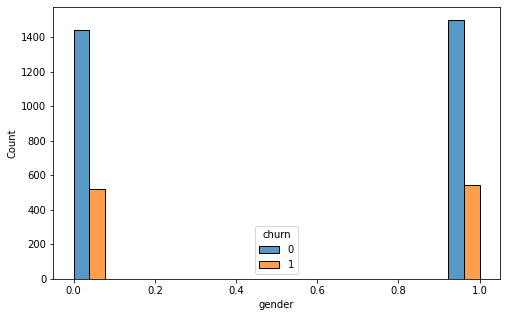


near_location


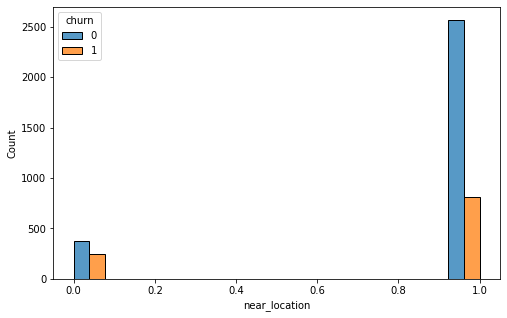


partner


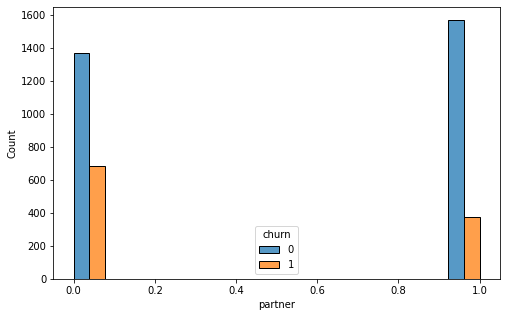


promo_friends


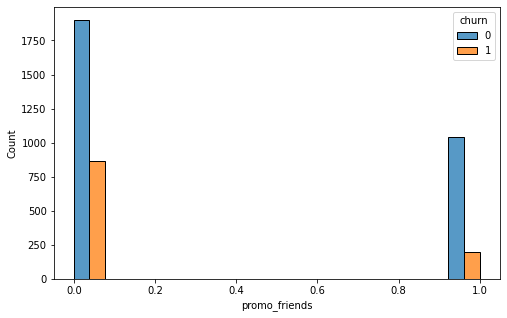


phone


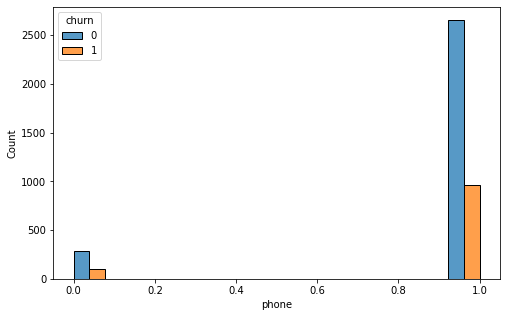


contract_period


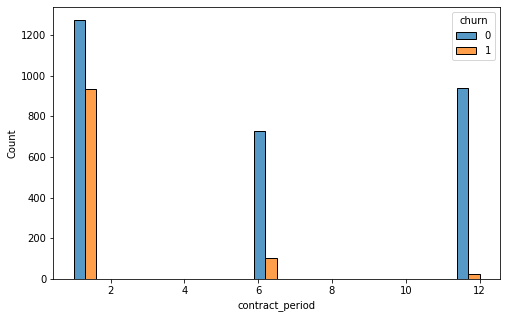


group_visits


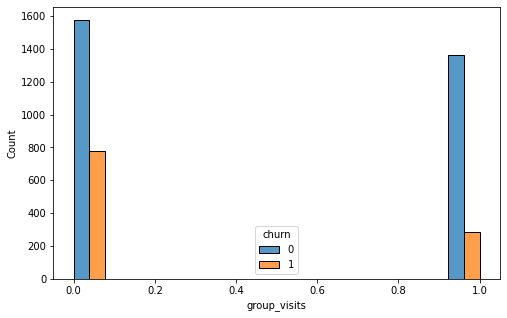


age


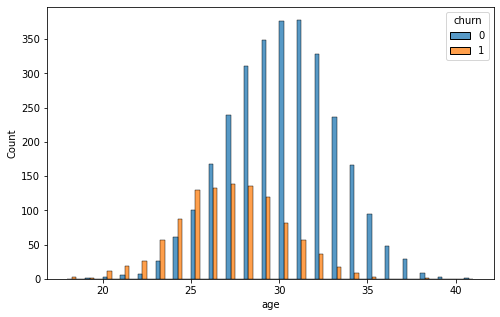


avg_additional_charges_total


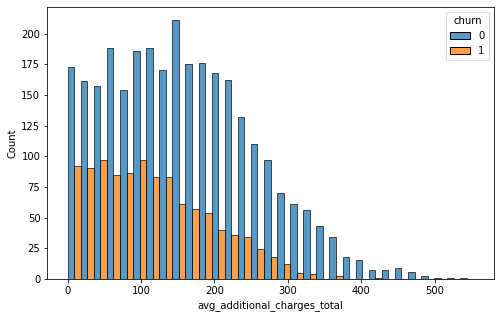


month_to_end_contract


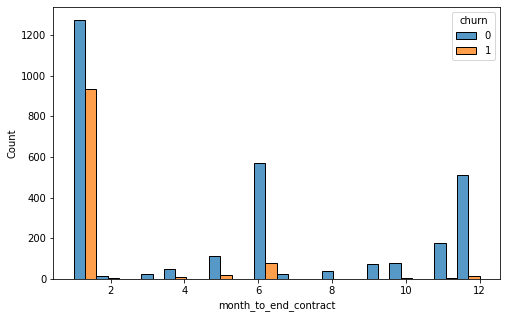


lifetime


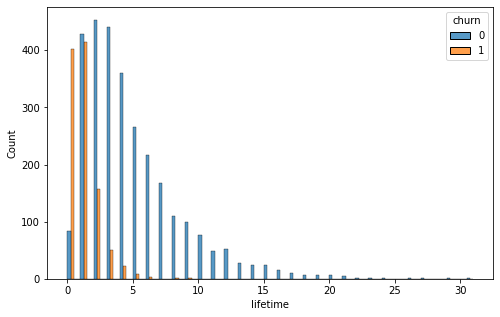


avg_class_frequency_total


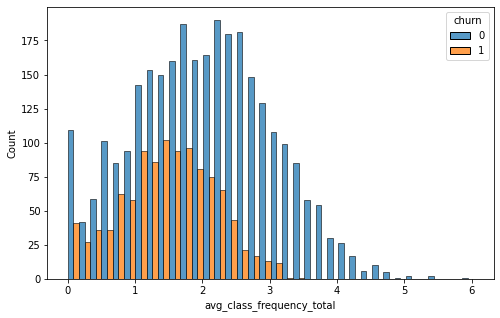


avg_class_frequency_current_month


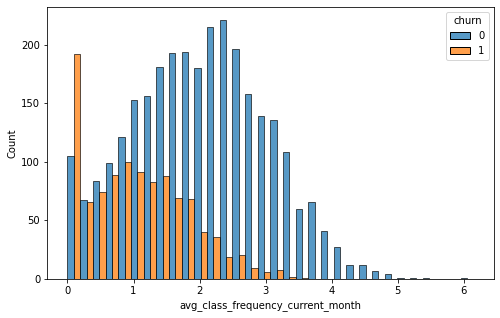

In [115]:
#Histogramas comparativos de características por grupo

for column in data.columns.drop('churn'):
    print(column)
    plt.figure(figsize=(8,5))
    sns.histplot(data=data, x=column, multiple="dodge", hue="churn")
    plt.show()
    print()

Con estos histogramas resultan evidentes algunos comportamientos, como la falta de asistencia a clases el último mes, lo cual se diferencia de manera significativa respecto a la asistencia general. Al contrario los cargos extras y la "vida" manejan comportamientos muy similares, indicando una cierta independencia de estos factores. Procedamos a un análisis con disgramas de dispersión sobre las columnas.

avg_additional_charges_total


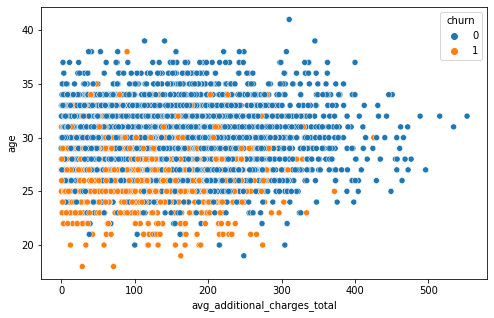


lifetime


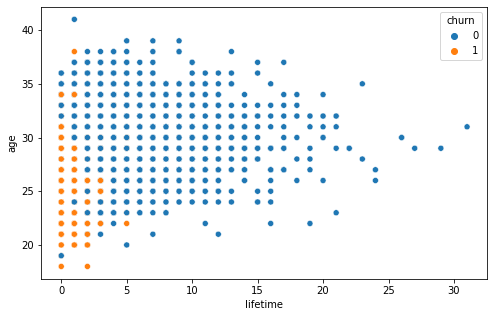


avg_class_frequency_total


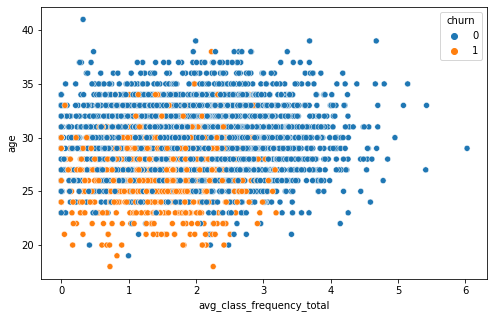


avg_class_frequency_current_month


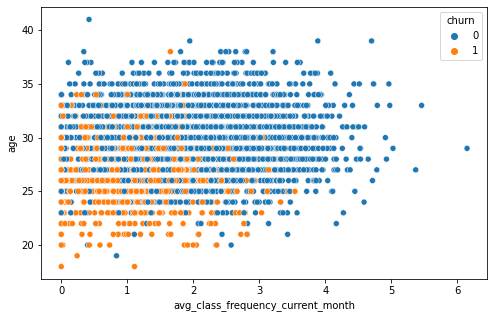

In [116]:
#Diagramas comparativos de características por grupo

for column in ['avg_additional_charges_total','lifetime','avg_class_frequency_total','avg_class_frequency_current_month']:
    print(column)
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=data, x=column, y='age', hue='churn')
    plt.show()
    print()

En estos diagramas comparando la edad contra otras características, podemos observar claramente cómo la gente con más edad y quienes ya tienen un hábito de años, permanecen, mientras que los más jovenes o nuevos a la experiencia tienden a irse, y son a quienes se debe buscar retener. Por el otro lado, vemos un comportamiento prácticamente idéntico de la edad contra la frecuencia de clases tanto general como del mes corriente, lo que parecería indicar que aunque hay relación entre la edad y la frecuencia, no existió un cambio en el comportamiento evidente, al contrario de visto en el histograma. A continuación dibujaremos un diagrama donde comparemos estas dos características.

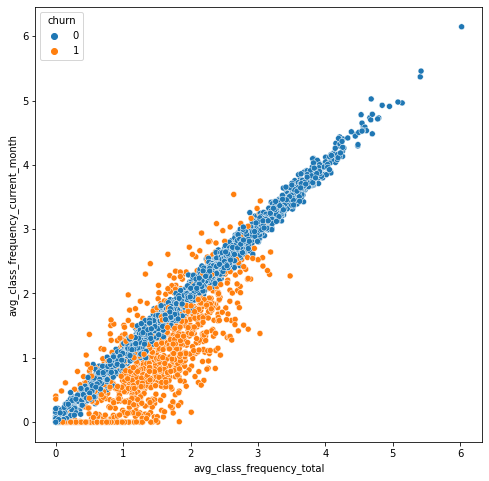

In [117]:
#Diagrama comparativo de frecuencia de clases general vs. mes corriente

plt.figure(figsize=(8,8))
sns.scatterplot(data=data, x='avg_class_frequency_total', y='avg_class_frequency_current_month', hue='churn')
plt.show()

En este último diagrama resulta muy evidente el cambio de comportamiento de los usuarios que estaban por salirse. En color azul podemos observar cómo quienes permanecieron simplemente mantuvieron su comportamiento rutinario; mientras que quienes abandonaron, en naranja, se alejaron de su comportamiento cotidiano, la mayoría disminuyendo la frecuencia de clases, pero otra cantidad significativa de usuarios aumentándola, lo que puede indicar que quisieron aprovechar al máximo su último mes.

Finalmente, procedamos a realizar una matriz de correlación, para evaluar este otro comportamiento de las características.

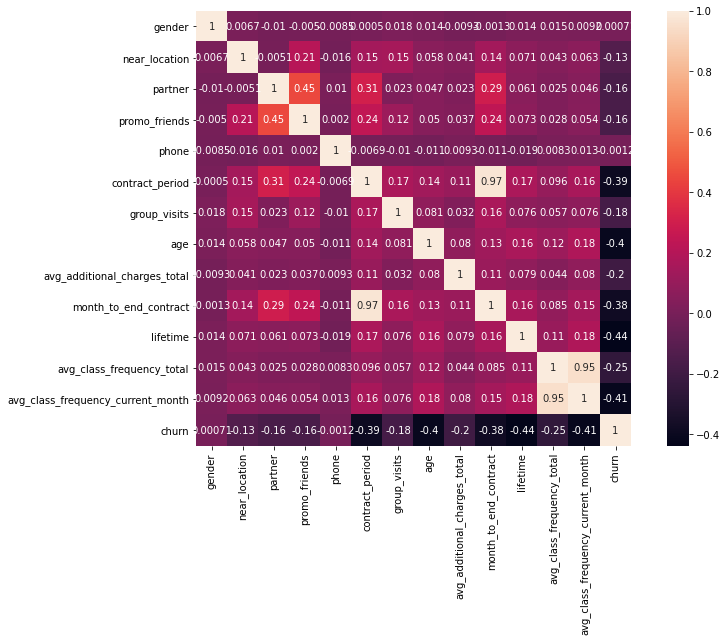

In [118]:
datacorr = data.corr()
plt.figure(figsize=(13,8))
sns.heatmap(datacorr, annot = True, square=True)
plt.show()

Gracias a este diagrama de calor sobre las correlaciones, podemos observar que las correlaciones más fuertes entre sí son entre la duración del contrato y los meses restantes, y entre las frecuencias de asistencia; mientras que las correlaciones que más se relacionan con el abandono de los clientes son el tiempo de "vida" de la membresía, la frecuencia en el mes corriente de asistencia a clases, la edad, la duración del contrato y los meses que faltan para terminar el contrato en ese orden.

Habiendo comprendido mejor el comportamiento de los clientes, sus comportamientos generales y aquellos previos a su cancelación, a continuación, procederemos a construir un modelo que nos ayude a predecir el abandono de los usuarios.

## Modelo para predecir la cancelación de usuarios

Se creará un modelo de clasificación binaria para el que el abandono del usuario en el siguiente mes es la catacterística objetivo. Para esto, primero se dividirán los datos, entre aquellos que utilizaremos para entrenamiento y validación, así como características y objetivo. Posteriormente se entrenará al modelo con dos métodos distintos que funcionan para la clasificación binaria: regresión logística y bosque aleatorio. Posteriormente, utilizando los datos de validación, procederemos a comparar ambos métodos a través de su exactitud, presición y recall, para definir el que mejores resultados terminará presentando.

Comencemos por la división de los datos, la cual realizaremos a un 80-20 entre los de entrenamiento y validación, como una medida conservadora que garantiza información suficiente para nutrir al modelo y para evaluarlo.

In [119]:
#División de los datos entre características y objetivo, y entre entrenamiento y validación

X = data.drop('churn', axis=1) #Características
y = data['churn'] #Objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Habiendo realizado la división de los datos, procederemos a la estandarización de las características de entrenamiento y aplicaremos esta misma a las de validación.

In [120]:
#Estandarización de características de entrenamiento

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)

#Aplicar misma estandarización a características de validación

X_test_st = scaler.transform(X_test)

A continuación se creará una función que ayude a entrenar y obtener las métricas correspondientes a ambos métodos que serán utilizados: regresión logística y bosque aleatorio.

In [121]:
#Determinación de los modelos

modelos = [LogisticRegression(), RandomForestClassifier()]

#Crear función para entrenar y evaluar modelos
def utilizar_modelos(modelo, X_train, y_train, X_test, y_test):
    model = modelo
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Exactitud: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Precisión: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
    print('F1: {:.2f}'.format(f1_score(y_test, y_pred)))

#Ejecusión de la función
for i in modelos:
    print(i)
    utilizar_modelos(i, X_train_st, y_train, X_test_st, y_test)
    print()

LogisticRegression()
Exactitud: 0.94
Precisión: 0.89
Recall: 0.86
F1: 0.87

RandomForestClassifier()
Exactitud: 0.92
Precisión: 0.88
Recall: 0.80
F1: 0.84



Gracias a estos resultados podemos comparar ambos modelos y elegir el que mejor nos vaya a apoyar para realizar futuras predicciones. En este caso, podemos observar que aunque el modelo de bosque aleatorio cuenta con métricas bastante positivas respecto a los resultados que se obtendrán de él, la regresión logística cuenta con características todavía mejores aumentando ligeramente la exactitud (resultados correctos sobre el total de resultados), pero considerablemente la precisión (positivos correctos del total de positivos obtenidos) y el recall (positivos correctos del total de positivos), así como la relación entre ellas (F1). Dado estos resultados se recomienda al Model Fitness que utilice la regresión logística para sus predicciones.

A continuación, dejando a un lado la columna de abandono, obtendremos clusters de los distintos usuarios de los gimnasios.

## Creación de clústeres de usuarios

Comenzando por estandarizar los datos de las características, utilizaremos linkage() y un dendograma para estimar el número de clusters que vamos a obtener. Entrenaremos un modelo con el método K-means. A partir de los clusters generados estudiaremos sus medias, trazaremos distribuciones de sus características y calcularemos la tasa de cancelación para cada uno.

Comencemos estandarizando los datos.

In [122]:
#Estandarización de las características

x_sc = scaler.fit_transform(X)

A continuación obtendremos el dendograma de las características estandarizadas.

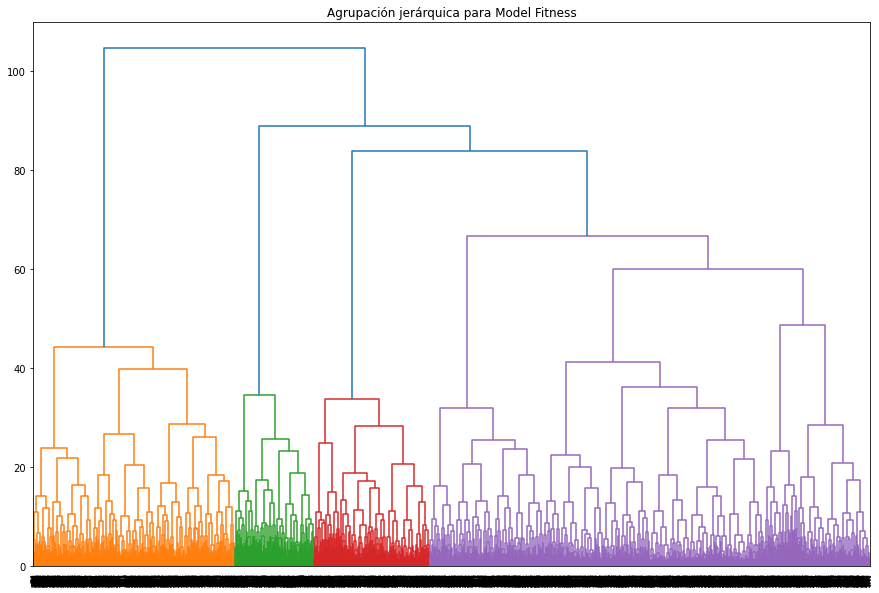

In [123]:
#Creación de dendograma

linked = linkage(x_sc, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Agrupación jerárquica para Model Fitness')
plt.show() 

Podemos observar, gracias al dendograma, que se está estimando un total de 4 clusters principales, sin embargo, para una mejor clasificación se tomarán 5, lo cual se obtiene disminuyendo ligeramente la distancia media, lo cual provoca que el cluster morado, el más grande, sea dividido en 2 partes. Este número de clusters es el que pasará como argumento al modelo que entrenemos con K-means.

In [124]:
#Determinar el modelo K-means con 5 clusters

km = KMeans(n_clusters = 5)

#Aplicar algoritmo y formar clusters

labels = km.fit_predict(x_sc)

# almacenar etiquetas de clúster en base de datos original

data['cluster_km'] = labels

#Obtener muestra
display(data.head(15))

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0,3
1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244,0,4
2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,1.736502,0,1
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0,4
4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,1.120078,0,1
5,1,1,0,0,1,1,1,34,450.743960,1,3,2.623477,2.637007,0,2
6,1,1,1,1,0,6,1,32,94.266389,6,2,1.138941,1.277242,0,3
7,0,1,0,0,1,1,0,30,217.786641,1,0,1.213502,1.049387,1,1
8,1,1,1,1,1,1,1,23,45.409909,1,1,1.106239,1.059333,0,1
9,0,1,0,0,1,1,0,31,65.310836,1,11,1.810852,1.951368,0,2


Ahora ya tenemos todos los registros de clientes en distintos clusters obtenidos por medio de K-means y añadimos su grupo (del 0 al 4) en la última columna de la tabla original.

Utilizando estos clusters, analicemos sus valores medios para comenzar a comprender su división.

In [125]:
#Obtener valores medios de las características por cluster

medias_cluster = data.groupby('cluster_km').mean()
display(medias_cluster)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
1,0.486122,1.000000,0.351308,0.239492,1.000000,1.953212,0.341792,28.168914,131.337907,1.861221,2.443299,1.246756,1.011916,0.513878
2,0.558057,0.976303,0.357820,0.233412,0.998815,2.681280,0.470379,30.104265,162.171247,2.471564,4.881517,2.848986,2.847392,0.068720
3,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
4,0.503483,0.959204,0.783085,0.574129,1.000000,10.913433,0.545274,29.996020,160.652278,9.975124,4.744279,1.979764,1.972271,0.027861


Podemos observar que exiten ciertas características sumamente determinantes para pertenecer o no a un cluster. Por ejemplo, aquellos que no están cercanos a la locación y aquellos que no dejaron un número telefónico tienen un promedio de cero absoluto, muy alejado de las medias de los otros clusters cercanas al 1. Por otro lado, vemos que el género es prácticamente independiente al cluster con una media alrrededor del 0.5 en todos, así como una edad alrrededor de los 29 años. En cuanto a las frecuencias de asistencia a clases, las cuales han resultado relevantes a lo largo de la investigación, al parecer una mayor frecuencia, tanto general como mensual, son determinantes para pertenecer al cluster 1.

Otra observación notable de estas medias, es que parece determinante para el cluster 0 el no haber llegado a través de la promoción de amigos.

Procederemos a trazar algunos diagramas para comprender mejor estos comportamientos a partir de una función.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


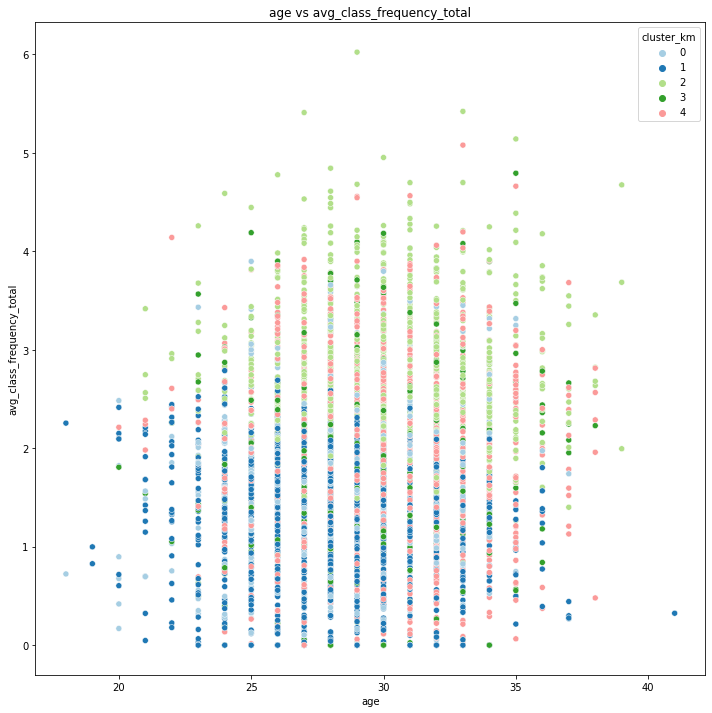

In [126]:
#Función para representación gráfica de características por clusters

def diagramar_clusters(df, x_sust, y_sust, cluster):
    plt.figure(figsize = (12,12))
    sns.scatterplot(df[x_sust], df[y_sust],
          hue = df[cluster], palette = 'Paired'
       )
    plt.title('{} vs {}'.format(x_sust, y_sust))
    plt.show()

#Edad vs Frecuencia general de asistencia a clases

diagramar_clusters(data, 'age', 'avg_class_frequency_total', 'cluster_km')

En el diagrama anterior puede observarse que claramente los clusters 1 y 2 están claramente diferenciados por la frecuencia general de asistencia a clases, mientras que la edad les resulta algo indistinta, mas no para el cluster 4, que se ve más presente conforme la edad va en aumento.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


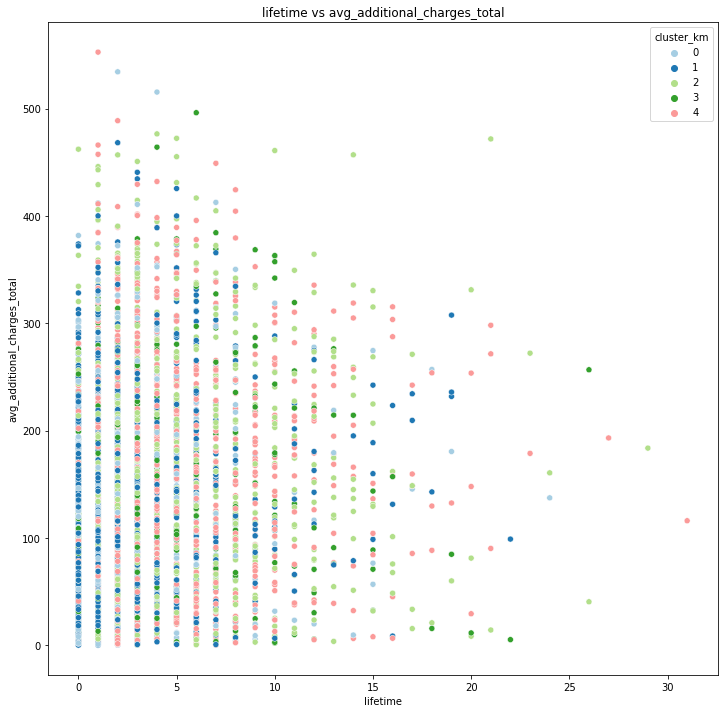

In [127]:
#Vida de la membresía vs Cargos adicionales

diagramar_clusters(data, 'lifetime', 'avg_additional_charges_total', 'cluster_km')

La vida de la membresía parecen ser determinante de la pertenencia al cluster 2, contando este con los miembros más recientes, para los otros clusters el tiempo de vida de la membresía parece ser irrelevante. Por el otro lado los cargos extras totales no parecen tener relevancia en la clasificación. Sin embargo el comportamiento general de la gráfica demuestra que conforme más tiempo llevan de ser miembros, menos propensos son a realizar los cargos extras, lo cual parece estar hablando de una mala selección o calidad de servicios extras, o una oferta concentrada en los clientes más jóvenes, lo cual demostraremos o refutaremos con la siguiente gráfica.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


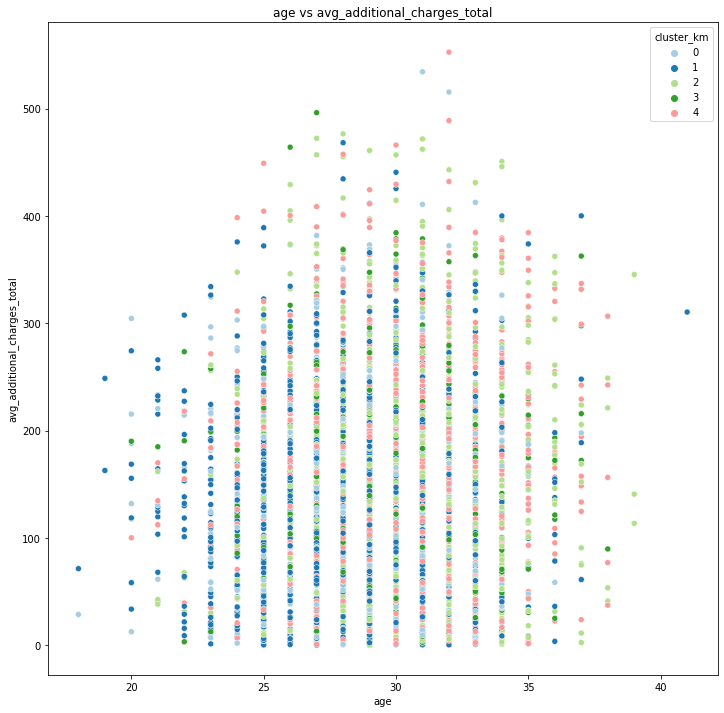

In [128]:
#Edad vs Cargos adicionales

diagramar_clusters(data, 'age', 'avg_additional_charges_total', 'cluster_km')

Gracias a esta gráfica podemos refutar que se estén brindando servicios específicos para ciertos segmentos de edad, ya que la distribución entre gastos extras y edad es bastante pareja, existiendo únicamente una ligera disminución en los extremos donde podríamos considerar que el nivel adquisitivo es menor. Esto mismo, junto con la gráfica anterior, nos dice que existe una mala selección o calidad de los servicios, ya que entre más tiempo llevan los clientes en el gimnasio menos consumen.

El siguiente diagrama, debido a las variables discretas que lo componen será obtenido con un efecto jitter, que permita una mejor visualización de los datos a través de un ligero desplazamiento aleatorio de sus ubicaciones, que todavía permita ubicar sus coordenadas de forma indudable.

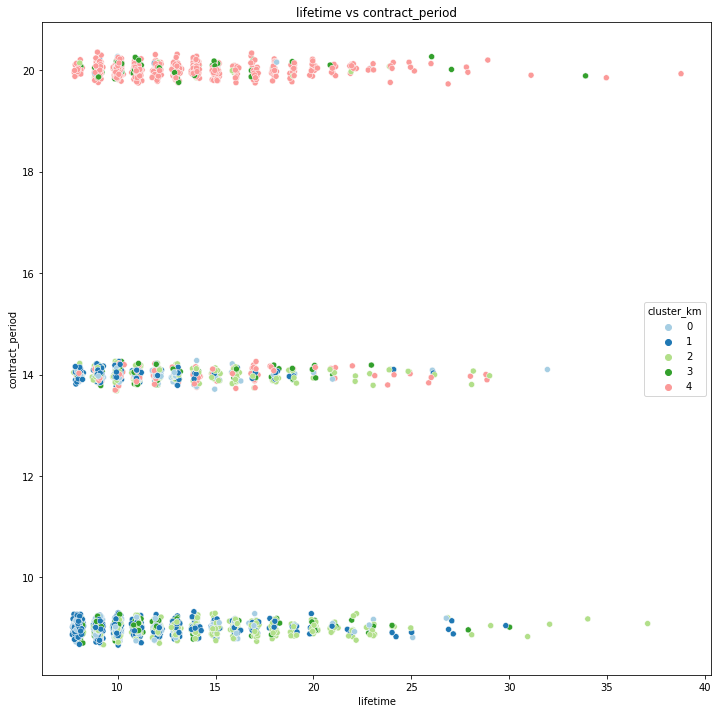

In [129]:
#Vida de la membresía vs Duración del contrato

def jitter(values,j):
    return values + np.random.normal(j,0.1,values.shape)

plt.figure(figsize = (12,12))
sns.scatterplot(x=jitter(data['lifetime'],8), y=jitter(data['contract_period'],8),
          hue = data['cluster_km'], palette = 'Paired'
       )
plt.title('{} vs {}'.format('lifetime', 'contract_period'))
plt.show()

En este gráfico, podemos observar lo determinante que resulta la duración del contrato para pertenecer al cluster 4 y la tendencia, mas no determinación de un contrato pequeño para pertenecer a los clusters 0 y 2.

Finalmente obtendremos una nueva visualización de la gráfica que confronta la frecuencia de clases general con la del último mes.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


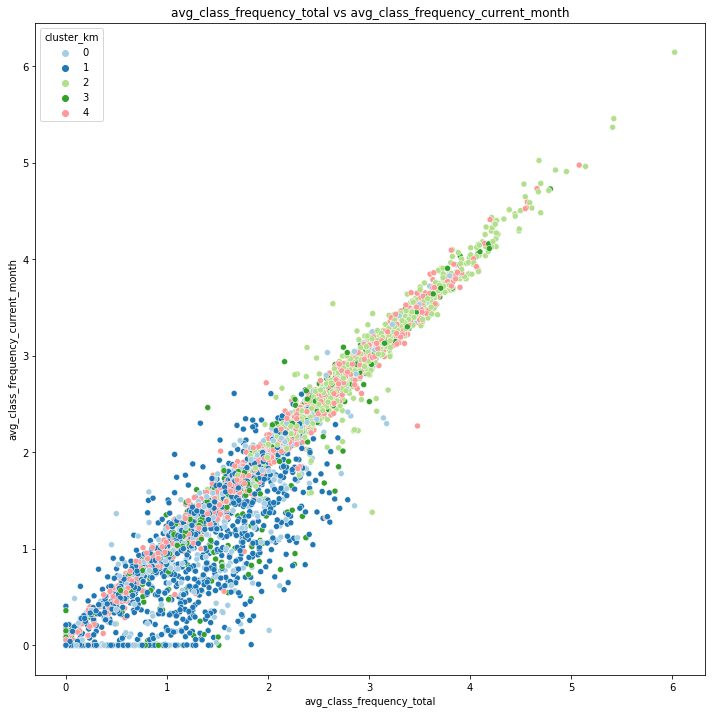

In [130]:
#Edad vs Frecuencia general de asistencia a clases

diagramar_clusters(data, 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'cluster_km')

Este diagrama resulta bastante ilustrativo ya que permite una relativamente clara distribución de los colores. Demostrando que la relación de estas variables es crucial para la clasificación de los clusters, siendo el cluster 3 el único que no está delimitado por un área en este gráfico. En los clusters 0 y 2 se encuentran claramentente los clientes que en el último mes más se apartaron de sus comportamientos habituales, mientras que los de los clusters 1 y 4 mantuvieron sus comportamientos, con los del cluster 1 con una frecuencia mayor a 2.5.

Este gráfico, con su división de los clusters, igualmente resulta muy relevante ya que a pesar de no considerarse la caracteristica objetivo en su agrupamiento, los clusters 0 y 2 coinciden con los abandonos.

Finalmente, nos fijaremos en la tasa de cancelación de los usuarios de los distintos clusters, la cual dada su naturaleza booleana, coincide con la media (suma de usuarios que abandonaron entre usuarios totales).

In [131]:
#Tasas de cancelación por cluster

display(data[['cluster_km', 'churn']].groupby('cluster_km').mean())

,churn
cluster_km,
0,0.443564
1,0.513878
2,0.068720
3,0.267532
4,0.027861


Como se pudo inferir de las gráficas que confrontaban las frecuencias general y de mes corriente de asistencia a clases, los clusters 0 y 2 son los que tienen una tasa significativamente mayor de abandono, con el cluster 2 presentando un .5. Entre las características definitorias para estos grupos que hemos estudiado, se encuentran:

Grupo 0:
* Alta variación en la frecuencia de asistencia a clases en el último mes
* Lejanos a la ubicación
* Contratos de poca duración
* Usuarios no llegaron a través de promoción de amigos

Grupo 2:
* Alta variación en la frecuencia de asistencia a clases en el último mes
* Contratos de baja o media duración
* Baja frecuencia de asistencia a clases
* Clientes más nuevos

## Conclusiones

La presente investigación ha brindado dos herramientas útiles para la generación de la estrategía de retención de clientes:

* Modelo para predecir la salida de clientes
* Identificación de clusters con su respectiva tasa de abandono

Se determinó que el modelo a utilizar fue el que aplicó la regresión logística, que presentaba las métricas más prometedoras en comparación con el modelo de bosque aleatorio, con una exactitud de 0.94, una presición de 0.89, un recall de 0.84 y un F1 de 0.87; lo cual indicaría buenas predicciones sin demasiado peligro de sobreajuste por la cantidad de registros utilizados.

En cuanto al clustering, que fue obtenido por medio de K-means en una división de 5 grupos, estimados por medio de un dendograma, se pudieron encontrar los clusters con mayor tasa de abandono y ubicar sus principales características, siendo estos los clusters 0 y 2.

Así mismo dentro de los análisis por medio de diagramas se pudieron observar ciertos comportamientos que igualmente podrían brindar buenas ideas para retención de clientes en el negocio, como brindar una buena selección y calidad de servicios, los cuales, en la actualidad, los clientes dejan de utilizar después de cierto tiempo.

Derivado de todo este análisis, se obtienen las siguientes recomendaciones para el negocio:

* **Fomentar el uso de la promoción de amigos** (La falta de su uso es determinante para pertencer a uno de los clusters con más alta tasa de abandono)

* **Abrir más ubicaciones** (La lejanía es determinante para pertencer a uno de los clusters con más alta tasa de abandono)

* **Promover contratos de larga duración** (Pueden compensarse ciertos descuentos o flexibilidades de pago con ingresos ajenos al contrato)

* **Promover periodos más largos de "vida" de las membresías** (Contar con descuentos los primeros meses, buscando generar el hábito de la asistencia puede convencer a quienes apenas están "conociendo", una media de "vida" de membresía es determinante para estar catalogado dentro del grupo con mayor tasa de abandono)

* **Cuidar los servicios para cargos extras que provee la cadena** (Aunque los gastos extras no resultan determinantes en la clasificación de los clusters, claramente se está perdiendo una oportunidad de ingreso, y además puede ser una variable que promueva la permanencia de los nuevos clientes)

* **Promover paquetes de clases para quienes han comenzado a bajar de su nivel de frecuencia de asistencia a clases habitual** (lo cual es determinante para pertencer a los dos grupos con mayor tasa de abandono)

* **Ofrecer recompensas a quienes suban su nivel de frecuencia de asistencia a clases habitual** (Se pudo observar que estos usuarios también terminan abandonando, puede ser que con un apoyo derivado de su escalamiento de participación, terminen convencidos de permanecer en el gimnasio).

Es importante considerar que el último punto se trataría más que nada de una estrategia defensiva, ya que muy probablemente el usuario aumentó su frecuencia de asistencia a clases derivado de haber decidido aprovechar lo más posible el último mes en el gimnasio.